In [112]:
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import joblib
import yaml
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import re
import random

from makers.model import build_model
from makers.utils import prepare, get_metrics

from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate, MaxPooling2D

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


# Config

In [188]:
DATA_PATH = "_input/data/book-COINBASE-BTC-USD.csv"
CONFIG_PATH = "_input/config.yml"
OUTDIR = '_output'
MODEL_TAG = 'Inception + testing set without look-ahead bias + smooth label'

In [187]:
# load config
config = yaml.safe_load(open(CONFIG_PATH, 'r'))

# specify paths
model_name = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(OUTDIR, 'models', model_name)
model_path = os.path.join(model_dir, 'model.h5')
metrics_path = os.path.join(model_dir, 'metrics.txt')
config_path = os.path.join(model_dir, 'config.yml')

os.makedirs(model_dir, exist_ok=True)

# Utils

In [7]:
def print_models():
    for model in sorted(os.listdir('_output/models')):
        fname = f"_output/models/{model}/metrics.txt"
        if not re.match('[\d]{8}_[\d]{6}', model) or not os.path.exists(fname):
            continue
        f = open(fname, 'r')
        print(f"{model}\n===========================================\n{f.read()}\n")

# Resampling

There are three labels: buy, hold and sell. The classes are imbalanced as there are many more hold samples compared to the other ones. In order to equalize the classes, one needs to either undersample the majority class, or oversample the minority classes.

In [183]:
def oversample(df, scaler, depth, window_size):
    
    idxnum = range(window_size, len(df))
    X1 = prepare(df, idxnum, depth, window_size)
    
    # encode labels
    y = df['signal2'].iloc[idxnum].to_numpy()
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))
    
    # split
    X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=False)
    
    # downsample neutral ones to have smaller training set
    step = 10
    non_neutral = np.where(np.argmax(y_train, axis=1) != 1)[0]
    neutral = np.setdiff1d(np.arange(len(y_train)), non_neutral)[::step]
    
    idx = np.hstack([non_neutral, neutral])
    X1_train, y_train = X1_train[idx], y_train[idx]
    
    # resample training set
    ros = RandomOverSampler(random_state=42)
    n_samples = X1_train.shape[0]
    X1_train, y_train = ros.fit_resample(X1_train.reshape((n_samples, -1)), y_train)
    
    n_samples = X1_train.shape[0]
    X1_train = X1_train.reshape((n_samples, window_size, 4 * depth, 1))
    
    # random reshuffle
    idx = np.random.permutation(len(X1_train))
    X1_train, y_train = X1_train[idx], y_train[idx]
    
    # scale training set
    n_samples = X1_train.shape[0]
    X1_train[:] = scaler.fit_transform(X1_train[:, :, :, 0].reshape((n_samples, -1))).reshape((n_samples, window_size, depth * 4, 1))
    
    # scale test set
    n_samples = X1_test.shape[0]
    X1_test[:] = scaler.transform(X1_test[:, :, :, 0].reshape((n_samples, -1))).reshape((n_samples, window_size, depth * 4, 1))

    # otherwise some classes are missing
    assert y_train.shape[1] == 3, "Some classes are missing."
    
    return X1_train, X1_test, y_train, y_test

## Load data

The data is sampled at 50ms. Each timestep has a UTC timestamp and 40 features: bid price and volume and ask price and volume, 10 levels deep.

Labels are quantized as follows:
* if the maximum ask price over the next 5 seconds - current ask price > threshold, label is +1
* if the current bid price - minimum bid price over the next 5 seconds > threshold, label is -1
* 0, otherwise

So thus it's a classification, and not a regression task (which is more common AFAIK), but we could build a regression model too.

In [16]:
# load dataset
print(f'Loading dataset {DATA_PATH}.')
df = pd.read_csv(DATA_PATH, index_col='timestamp', parse_dates=True).sort_index()

# dedupe
df = df[~df.index.duplicated(keep='first')]

Loading dataset _input/data/book-COINBASE-BTC-USD.csv.


## Labels using running min/max

In [ ]:
# we use the fact that data is sampled at 50ms
window = f"{config['model']['prediction_horizon']}s"
min_periods = config['model']['prediction_horizon']

# calculate indicators (use [::-1] to have rolling windows for successive, not trailing timesteps)
df['p+'] = df['ap0'][::-1].rolling(window, min_periods=min_periods).max()[::-1] - df['ap0']
df['p-'] = df['bp0'] - df['bp0'][::-1].rolling(window, min_periods=min_periods).min()[::-1]

# calculate labels
df['signal'] = (df['p+'] > config['model']['threshold']).astype(int) - (df['p-'] > config['model']['threshold']).astype(int)


## Smoothed labels as in the original paper

In [ ]:
# calculate smoothed labels
# https://arxiv.org/pdf/1808.03668.pdf, p. 4

# use 20, given 50ms interval corresponds to 1s
kernel_size = 20
label_threshold = 5e-5

# midprice
mid_price = (df['ap0'] + df['bp0']) / 2

df['m+'] = mid_price.shift(-(kernel_size - 1)).rolling(kernel_size).mean()
df['m-'] = mid_price.rolling(kernel_size).mean()
df['y1'] = (df['m+'] - mid_price) / mid_price
df['y2'] = (df['m+'] - df['m-']) / df['m-']

df['signal2'] = -1 + 1. * (df['y2'] >= -label_threshold) + 1. * (df['y2'] >= label_threshold)

In [178]:
# remove na
df = df[~df.isna().any(axis=1)]


(array([124861.,      0.,      0.,      0.,      0., 454512.,      0.,
             0.,      0., 119700.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

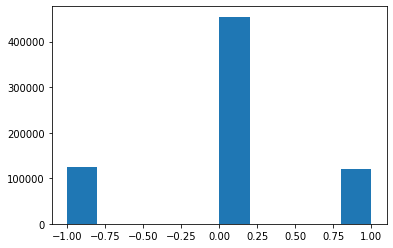

In [182]:
# Classes are imbalanced, need resampling to equalize them.
plt.hist(df['signal'])

# Resampling

/home/mathematik/starokon/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


(array([96932.,     0.,     0.,     0.,     0., 96932.,     0.,     0.,
            0., 96932.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

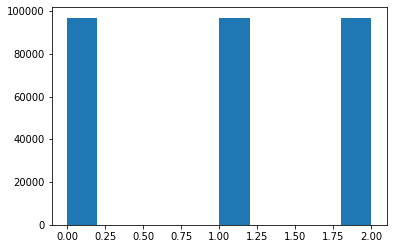

In [189]:
# resample and split

scaler = StandardScaler()

assert config['model']['resampling'] in ['undersample', 'oversample']

if config['model']['resampling'] == 'undersample':
    X1_train, X1_test, y_train, y_test = undersample(df, scaler, config['model']['depth'], config['model']['window_size'])
elif config['model']['resampling'] == 'oversample':
    X1_train, X1_test, y_train, y_test = oversample(df, scaler, config['model']['depth'], config['model']['window_size'])
    
plt.hist(np.argmax(y_train, axis=1))


In [190]:
# dump scaler into file
scaler_path = os.path.join(model_dir, 'scaler.h5')
joblib.dump(scaler, scaler_path)

['_output/models/20220219_235403/scaler.h5']

# Model

In [191]:
def build_model(window_size, depth):

    input_layer1 = Input(shape=(window_size, depth * 4, 1))
    # input_layer2 = Input(shape=(window_size, n_features))

    # conv layers
    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)

    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)

    x = Conv2D(16, kernel_size=(1, depth), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    # inception module
    y1 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(x)
    y1 = Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same')(y1)

    y2 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(x)
    y2 = Conv2D(32, kernel_size=(5, 1), activation='relu', padding='same')(y2)

    y3 = MaxPooling2D(pool_size=(4, 1), strides=(1, 1), padding='same')(x)
    y3 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(y3)

    x = concatenate([y1, y2, y3])
    x = Reshape((window_size, 32 * 3))(x)

    # x = concatenate([x, input_layer2])

    # LSTM
    lstm_layer = LSTM(64)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.8)(bn_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    # model = Model([input_layer1, input_layer2], output_layer)
    model = Model(input_layer1, output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [192]:
# build and train model

model = build_model(window_size=config['model']['window_size'], depth=config['model']['depth'])
cp_callback = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', save_weights_only=True,
                              save_best_only=True)

In [193]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 20, 20, 16)   48          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 20, 20, 16)   1040        conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 20, 20, 16)   1040        conv2d_43[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = model.fit(X1_train, y_train,
                    epochs=config['training']['n_epochs'],
                    batch_size=config['training']['batch_size'],
                    validation_split=0.15, callbacks=[cp_callback],
                    verbose=2)

In [195]:
# save history
history_path = os.path.join(model_dir, 'history.csv')
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_path, index=False)

In [196]:
# load the best model
model.load_weights(model_path)

In [197]:
# training performance

loss, accuracy = model.evaluate(X1_train, y_train, verbose=0)

y_pred_num = np.argmax(model.predict(X1_train), axis=1)
y_test_num = np.argmax(y_train, axis=1)

metrics = get_metrics(y_test_num, y_pred_num)

output = (
    f"{MODEL_TAG}\n\n"
    f"{'loss':20}{loss:7.4f}\n"
    f"{'accuracy':20}{accuracy:7.4f}\n\n"
    f"{metrics}"
)

print(output)


Inception + testing set without look-ahead bias + smooth label

loss                 0.5953
accuracy             0.7365

r2                     0.54
precision            0.8824  0.5998  0.8033
recall               0.6652  0.7660  0.7784
fscore               0.7586  0.6728  0.7907
support               96932   96932   96932

confusion matrix    
  64479   29309    3144
   7351   74251   15330
   1240   20240   75452



In [198]:
# testing performance

loss, accuracy = model.evaluate(X1_test, y_test, verbose=0)

y_pred_num = np.argmax(model.predict(X1_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)

metrics = get_metrics(y_test_num, y_pred_num)

output = (
    f"{MODEL_TAG}\n\n"
    f"{'loss':20}{loss:7.4f}\n"
    f"{'accuracy':20}{accuracy:7.4f}\n\n"
    f"{metrics}"
)

print(output)

f = open(metrics_path, 'w')
f.write(output)
f.close()
print(f"Metrics written to {metrics_path}.")

yaml.dump(config, open(config_path, 'w'))
print(f"Config copied to {config_path}.")


Inception + testing set without look-ahead bias + smooth label

loss                 0.8921
accuracy             0.6343

r2                    -0.11
precision            0.5576  0.7629  0.4660
recall               0.5772  0.6337  0.6948
fscore               0.5672  0.6923  0.5579
support               27909   84690   27212

confusion matrix    
  16110    9495    2304
  11660   53669   19361
   1122    7183   18907

Metrics written to _output/models/20220219_235403/metrics.txt.
Config copied to _output/models/20220219_235403/config.yml.


In [199]:
print_models()

20220219_215213
Inception + testing set without look-ahead bias

loss                 0.5732
accuracy             0.8898

r2                    -2.82
precision            0.0231  0.9715  0.0307
recall               0.0605  0.9153  0.0923
fscore               0.0334  0.9426  0.0461
support                1867  135571    2405

confusion matrix    
    113    1629     125
   4605  124091    6875
    172    2011     222


20220219_235403
Inception + testing set without look-ahead bias + smooth label

loss                 0.8921
accuracy             0.6343

r2                    -0.11
precision            0.5576  0.7629  0.4660
recall               0.5772  0.6337  0.6948
fscore               0.5672  0.6923  0.5579
support               27909   84690   27212

confusion matrix    
  16110    9495    2304
  11660   53669   19361
   1122    7183   18907




# Backtesting

The goal is for the model to perform well out-of-sample (=for different time period), but as a sanity check, we first want to ensure that it performs well in-sample.

In [148]:
idxnum = range(100, len(df))

# prepare model
X1 = prepare(df, idxnum, config['model']['depth'], config['model']['window_size'])

# rescale
n_samples = X1.shape[0]
X1[:] = scaler.transform(X1[:, :, :, 0].reshape((n_samples, -1))).reshape((n_samples, config['model']['window_size'], config['model']['depth'] * 4, 1))

# encode labels
y = df['signal'].iloc[idxnum].to_numpy()
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y.reshape(-1, 1))

X1.shape, y.shape


((699134, 20, 40, 1), (699134, 3))

In [149]:
# predict labels
ret_pred = model.predict(X1)
strategy = np.argmax(ret_pred, axis=1) - 1.

# calculating strategy
df.loc[df.index[idxnum], ['g-', 'g0', 'g+']] = ret_pred
df.loc[df.index[idxnum], 'signal_pred'] = strategy.reshape(-1)

df_strategy = df[~df.isna().any(axis=1)]
df_strategy.shape

(699134, 47)

<AxesSubplot:xlabel='timestamp'>

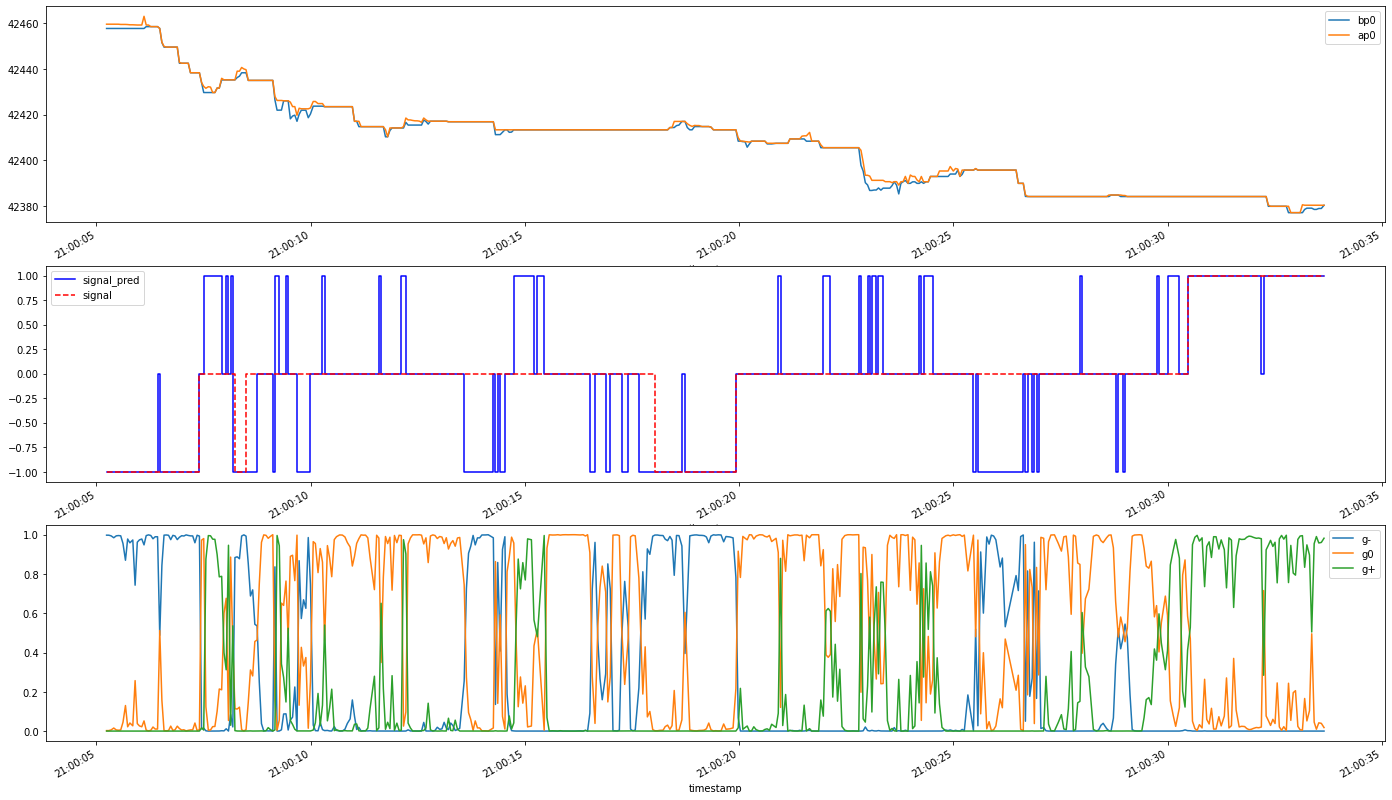

In [42]:
fig, ax = plt.subplots(nrows=3, figsize=(24, 15))

offset, step = 0, 500

df_strategy[offset:offset+step][['bp0', 'ap0']].plot(ax=ax[0])
df_strategy[offset:offset+step][['signal_pred']].plot(ax=ax[1], drawstyle="steps", c='b')
df_strategy[offset:offset+step][['signal']].plot(ax=ax[1], drawstyle="steps", c='r', linestyle='dashed')
df_strategy[offset:offset+step][['g-', 'g0', 'g+']].plot(ax=ax[2])